<a href="https://colab.research.google.com/github/pachterlab/monod_examples/blob/main/Monod_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Monod* on Colab

In the current notebook, we apply *Monod* to identify differentially regulated genes between GABAergic and glutamatergic cell types in a single Allen dataset. 

# Inference pipeline

## Define aesthetics

In [1]:
import time
t1 = time.time()
#a e s t h e t i c s

fs = 16
nbin=40

#https://github.com/BlakeRMills/MetBrewer
# Degas=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29")
# Demuth = ("#591c19", "#9b332b", "#b64f32", "#d39a2d", "#f7c267", "#b9b9b8", "#8b8b99", "#5d6174", "#41485f", "#262d42")


## Install prerequisites

In [2]:
# %%capture
!pip install -i https://test.pypi.org/simple/ -U --extra-index-url https://pypi.org/simple   monod  
# !pip install -i https://pypi.org/simple/  monod  

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.org/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 1.1 MB/s eta 0:00:00
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52035 sha256=5e915bed2ca0079d0ae9c574222018f6fb0d530cf588514b4c9f0b64da0f7ae3
  Stored in directory: /root/.cache/pip/wheels/d9/b5/43/cab70cefd40f17c3c39ba18d115ee28b76c6a076dee5abda6e
Successfully built loompy


Let's make sure that the version is correct.

In [3]:
!pip show monod

Name: monod
Version: 0.2.6.0
Summary: the Monod package fits CME models to sequencing data.
Home-page: https://github.com/pachterlab/monod
Author: Gennady Gorin, Lior Pachter
Author-email: ggorin@caltech.edu, lpachter@caltech.edu
License: 
Location: /usr/local/lib/python3.9/dist-packages
Requires: anndata, loompy, numdifftools, numpy, pytz, scipy
Required-by: 


## Import data

In [4]:
! git clone https://github.com/pachterlab/monod_examples.git

Cloning into 'monod_examples'...
remote: Enumerating objects: 1275, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 1275 (delta 103), reused 215 (delta 103), pack-reused 1059
Receiving objects: 100% (1275/1275), 1.01 GiB | 24.10 MiB/s, done.
Resolving deltas: 100% (447/447), done.
Updating files: 100% (177/177), done.


In [5]:
!rm -r sample_data

In [6]:
!mv monod_examples/* .

In [7]:
!mv sample_data/* .

In [15]:
!cat allen_C01_gaba.tar.gz.* | tar xzvf -
!mv home/ggorin/projects/monod_examples/sample_data/allen_C01_gaba.loom .
!cat allen_C01_glu.tar.gz.* | tar xzvf -


home/ggorin/projects/monod_examples/sample_data/allen_C01_gaba.loom


In [19]:
!rm -r  ./home

In [21]:
!rm *.tar.*

## Import package components

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


## Define metadata

In [3]:
dataset_names = ['allen_C01_gaba','allen_C01_glu'] 
loom_filepaths = ['./'+x+'.loom' for x in dataset_names] 

transcriptome_filepath = './polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=[('unspliced','spliced'),'gene_name','barcode']

In [4]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')

## Run pre-processing

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230417_026_mouse_1 already exists.
INFO:root:Dataset: allen_C01_gaba
INFO:root:728 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:4994 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230417_026_mouse_1/allen_C01_gaba already exists.
INFO:root:Dataset: allen_C01_glu
INFO:root:4674 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7049 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230417_026_mouse_1/allen_C01_glu already exists.
INFO:root:Gene set size according to a 100.0% dataset threshold: 4713
INFO:root:250 random genes selected.
INFO:root:Total of 250 genes selected.
INFO:root:Directory ./fits/gg_230417_026_mouse_1/diagnostic_figures already exists.


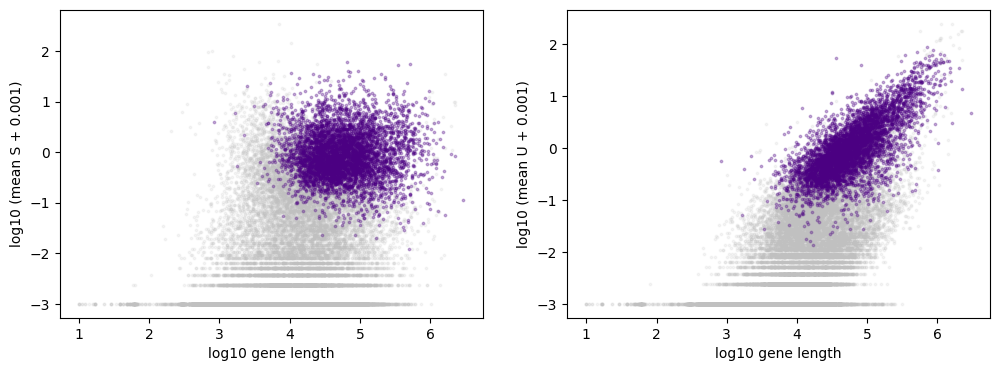

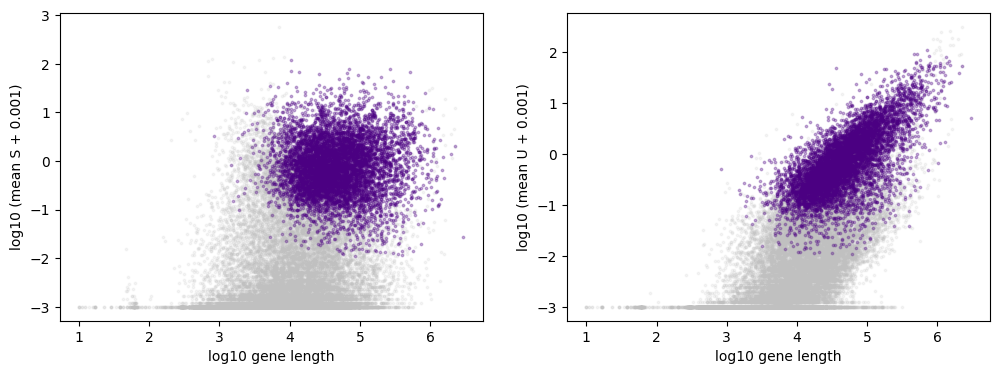

In [5]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='mouse',batch_id=1,\
                                             n_genes=250,datestring='230417')

## Run inference

In this example, we will fit the bursty model to the two cell types, using a Poisson sampling model on a $6\times 7$ grid. For this Colaboratory notebook, we only use 5 iterations from the MoM estimate. 

The first argument of `fit_all_grid_points` is the number of cores to parallelize over. On Colab, only 1 core can be used without crashing.

INFO:root:Directory ./fits/gg_230417_026_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230417_026_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_C01_gaba
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230417_026_mouse_1/genes.csv.
INFO:root:Directory ./fits/gg_230417_026_mouse_1/allen_C01_gaba/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230417_026_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230417_026_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures created.
INFO:root:Runtime: 585.7 seconds.
INFO:root:Directory ./fits/gg_230417_026_mouse_1/allen_C01_glu/Bursty_Pois

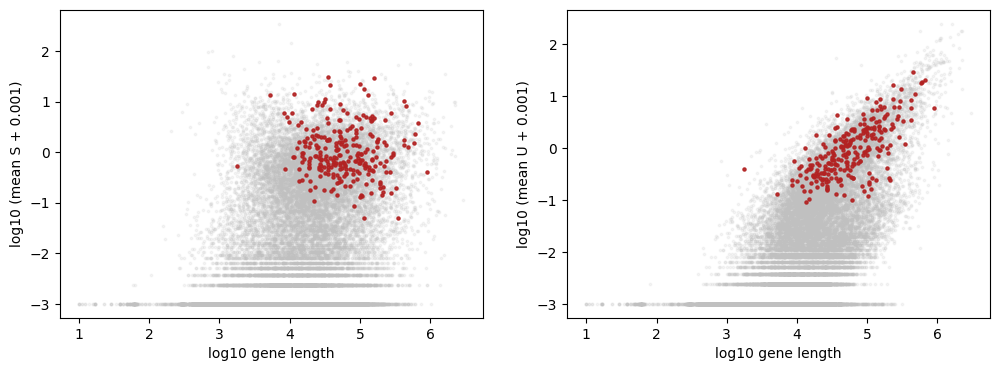

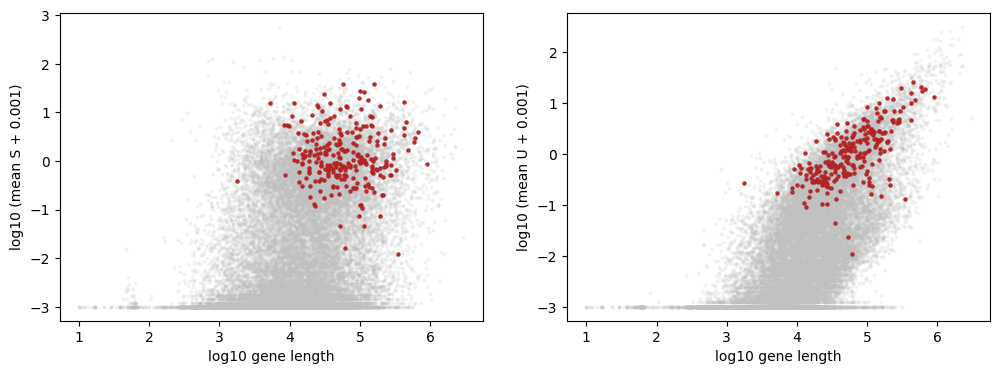

In [6]:
n_datasets = len(dataset_names)
lb = [-1.0, -1.8, -1.8 ]
ub = [4.2, 2.5, 3.5]
grid = [6,7]

result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(lb,ub,[-8, -3],[-5, 0],grid,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                        dataset_strings[i], dir_string, dataset_attr_names=attribute_names)
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings.append(full_result_string)


In [7]:
%%capture
!tar -czvf sample_fits.tar.gz fits

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Analysis

## Post-processing and QC

Load in search data.

In [8]:
dir_string = './fits/gg_230417_026_mouse_1'
dataset_strings = [dir_string+'/'+x for x in dataset_names]
result_strings = [x+'/Bursty_Poisson_6x7/grid_scan_results.res' for x in dataset_strings]

sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(x+'/raw.sd') for x in dataset_strings]

INFO:root:Grid scan results loaded from ./fits/gg_230417_026_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230417_026_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230417_026_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230417_026_mouse_1/allen_C01_glu/raw.sd.


Inspect all bursty result files and perform basic QC. We would like to be confident of the typical results:

*   The fits successfully recapitulate the joint count distributions
*   The sampling parameters appear to have a single unique optimum in $\{C_u, \lambda_s\}$
*   The physical parameters $\{b,\beta,\gamma\}$ are largely independent of gene length
*   The physical parameter distributions are consistent with a normal-inverse Gaussian law

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def run_qc(j):
    sr = sr_arr[j]
    sd = sd_arr[j]
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)



    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,viz=True) 

    sr.compute_sigma(sd,num_cores=1) #colab has a hard time with multiprocessing
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()


INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230417_026_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230417_026_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 44 genes out of 250. Runtime: 1.0 seconds.
INFO:root:Figure stored to ./fits/gg_230417_026_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_230417_026_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.80, -1.00.
INFO:root:Chi-square computation complete. Rejected 44 genes out of 250. Runtime: 1.4 seconds.
INFO:root:New optimum: -6.80, -1.00.
INFO:root:Chi-square computation complete. Rejected 44 genes out of 250. Runtime: 1.7 seconds.
INFO:root:New optimum: -6.80, -1.00.
INFO:root:Chi-square computation

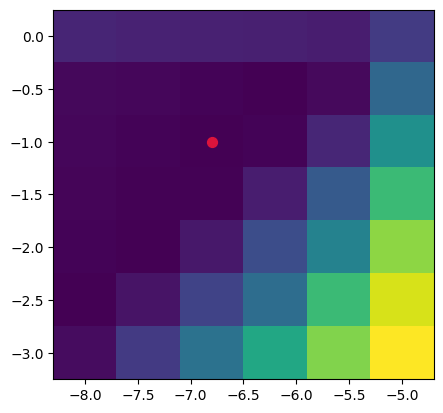

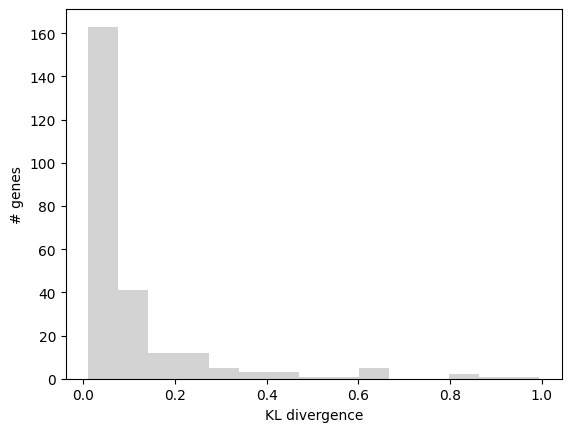

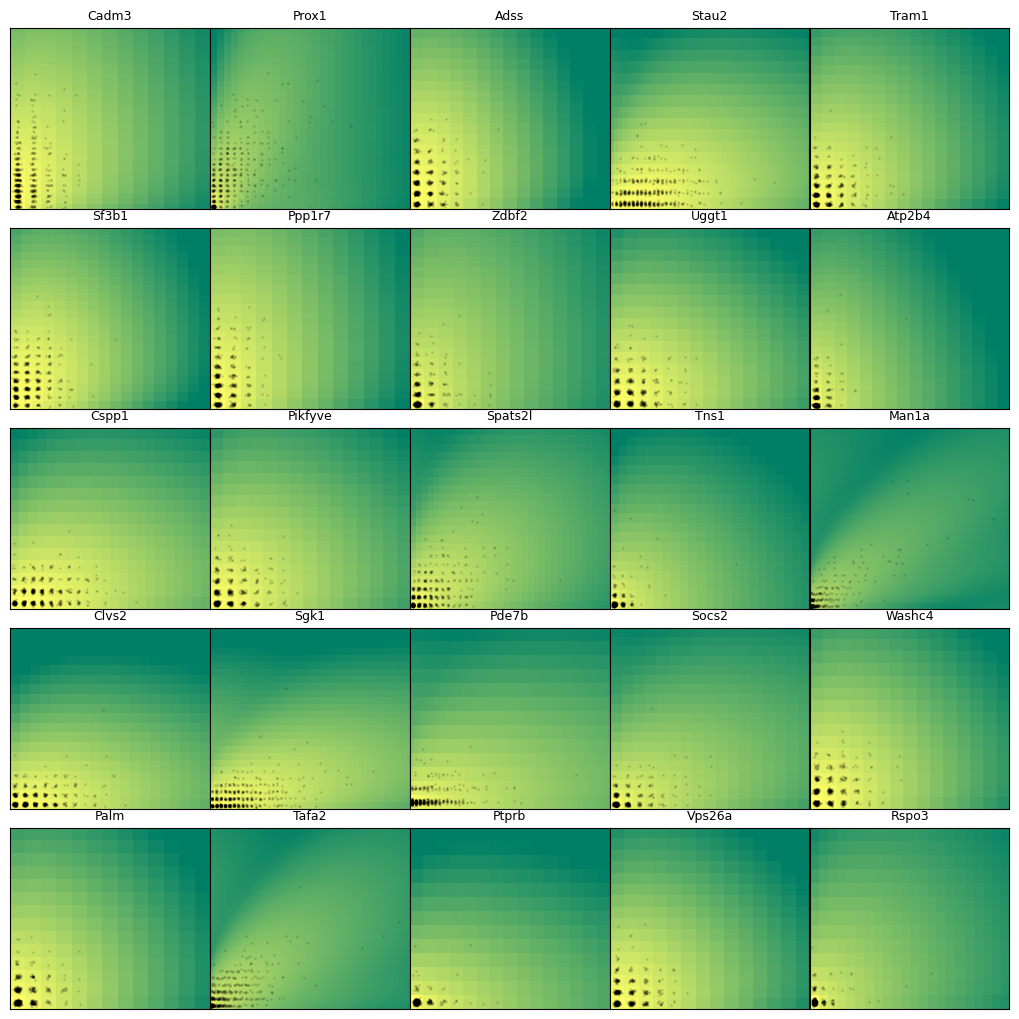

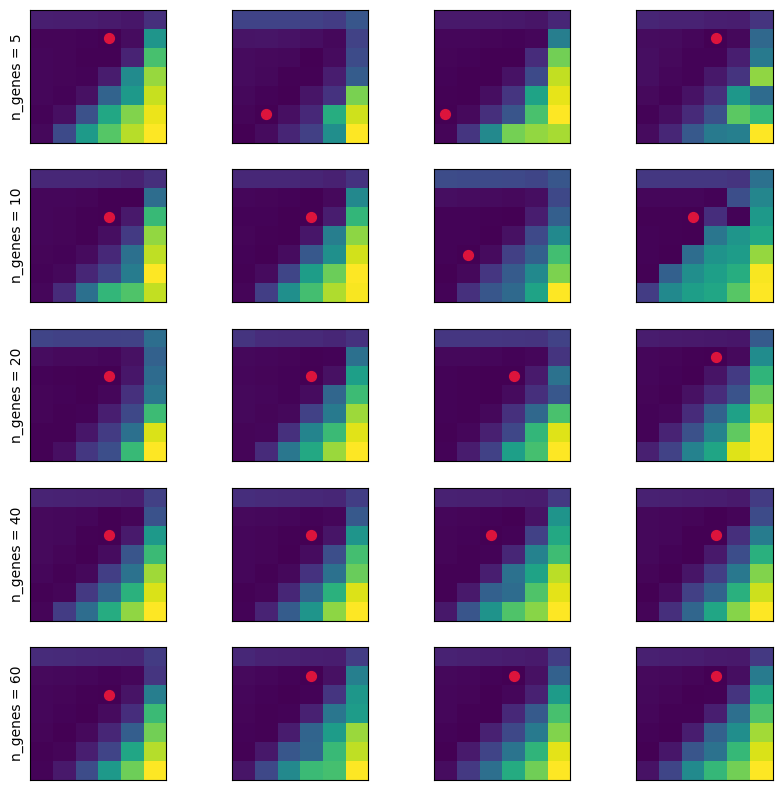

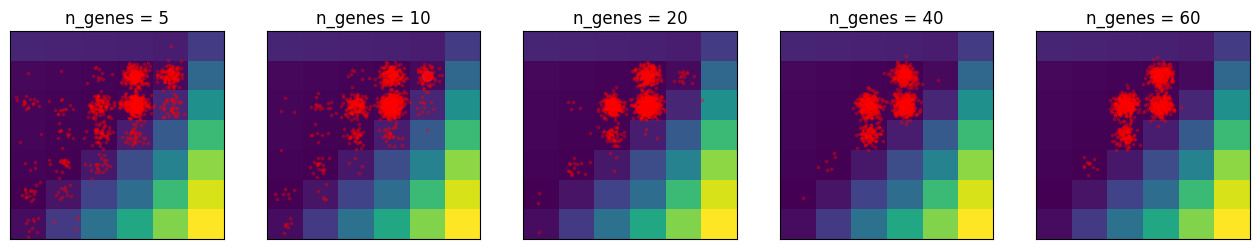

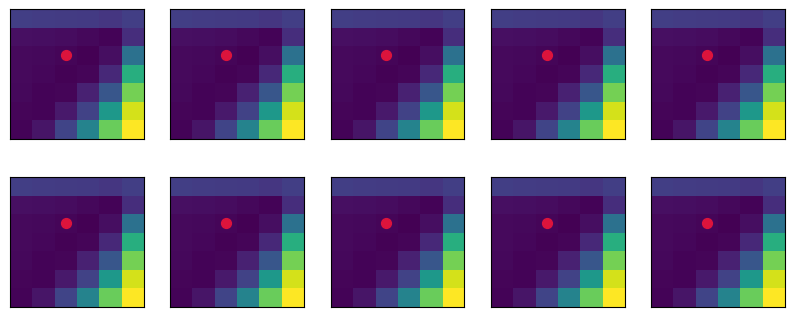

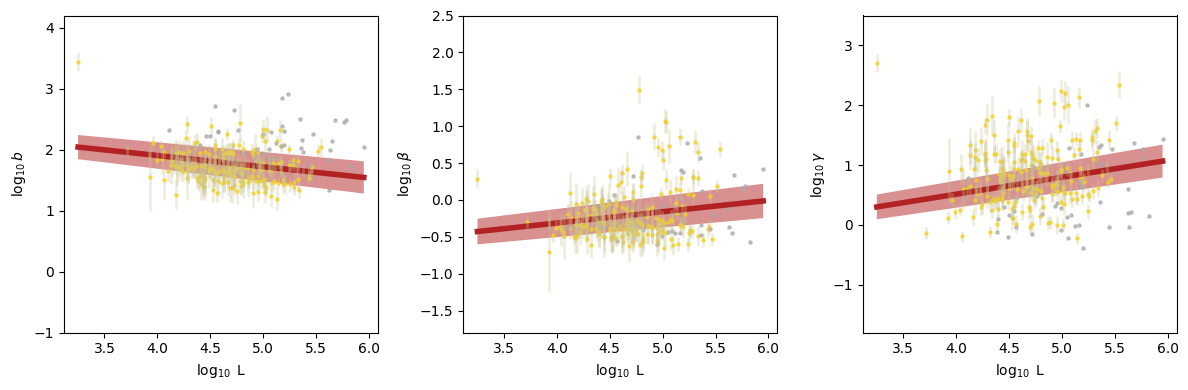

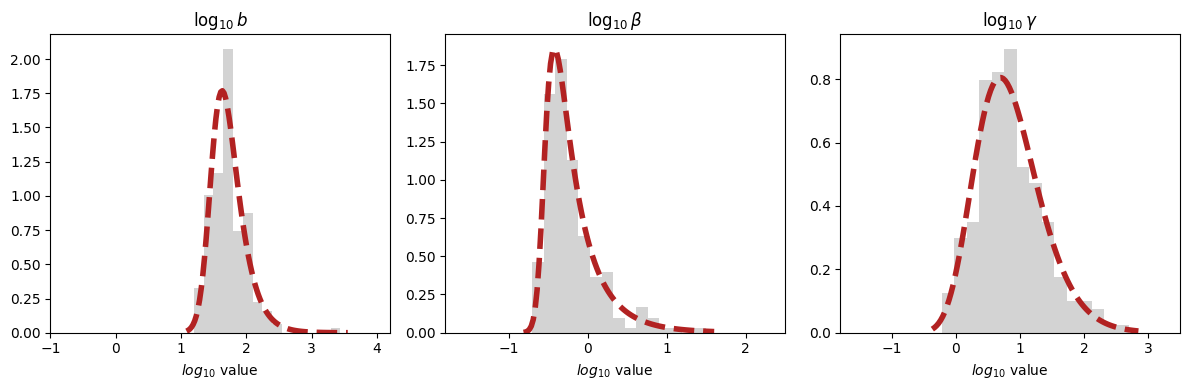

In [11]:
run_qc(0)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230417_026_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230417_026_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 20 genes out of 250. Runtime: 2.1 seconds.
INFO:root:Figure stored to ./fits/gg_230417_026_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_230417_026_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/subsampling_sta

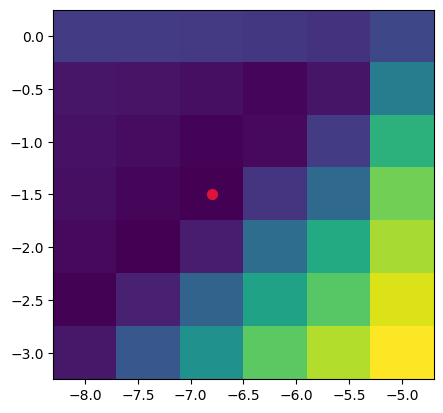

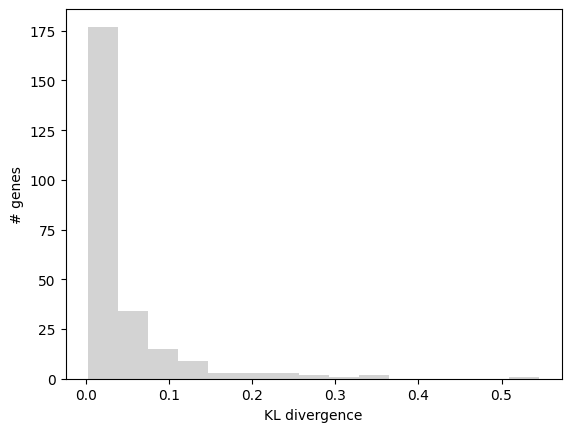

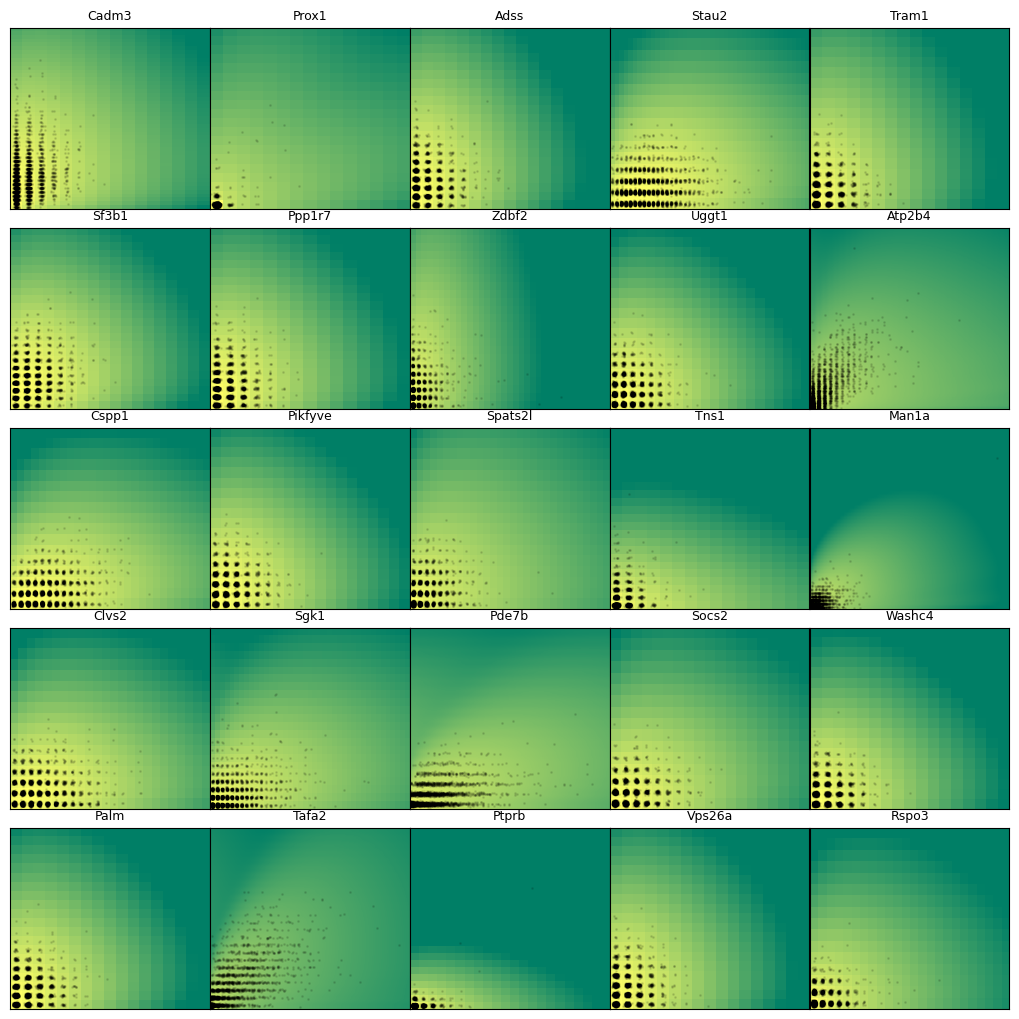

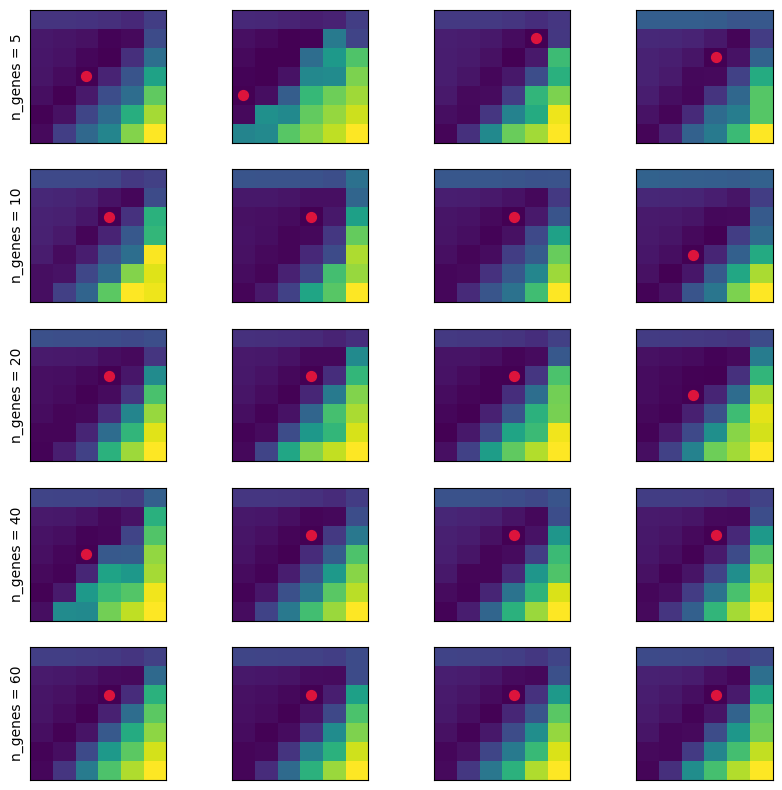

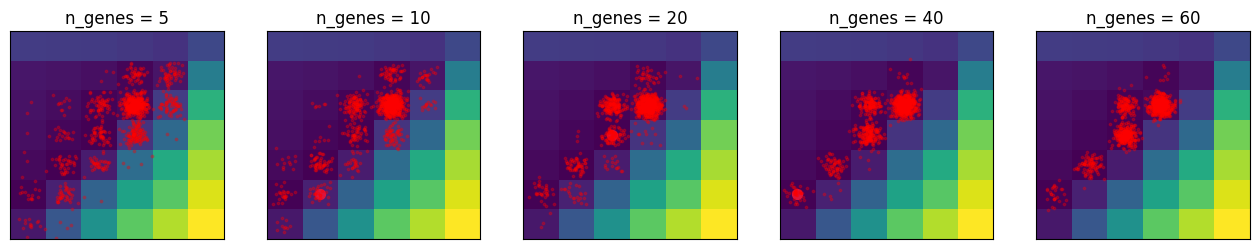

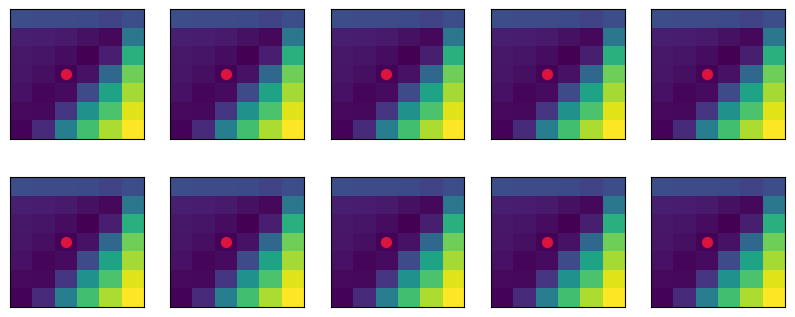

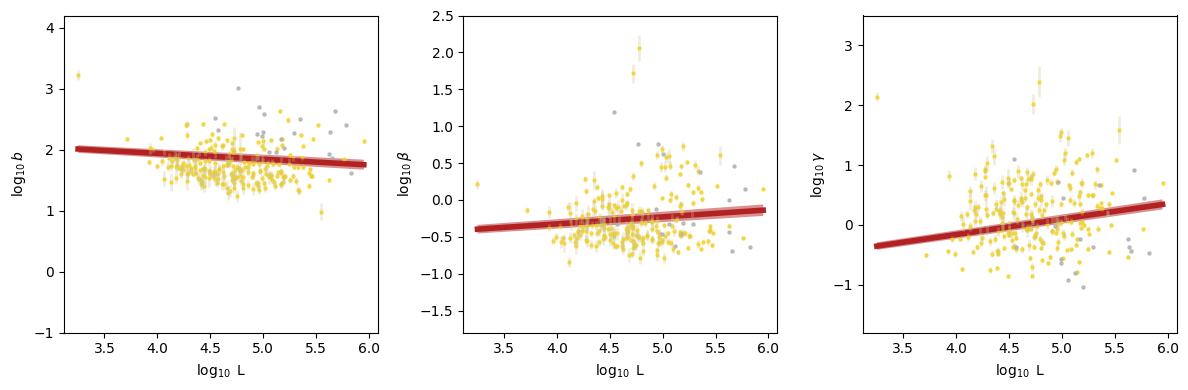

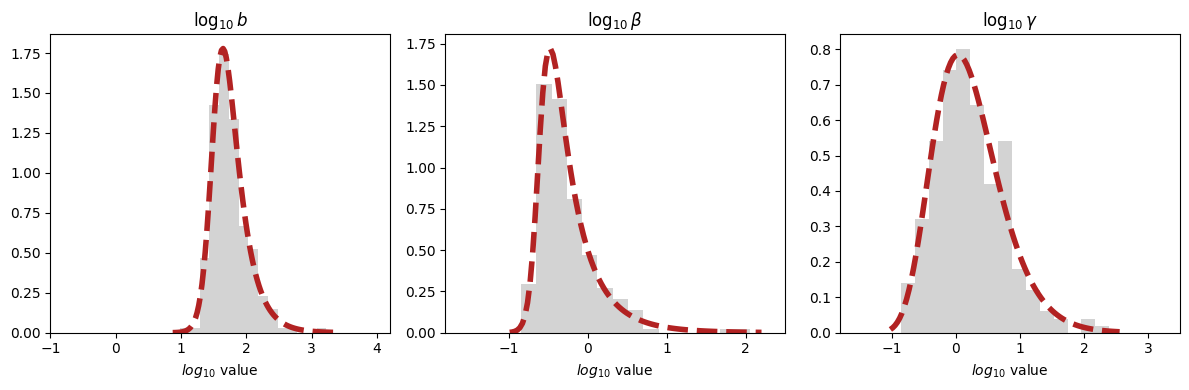

In [12]:
run_qc(1)

In [13]:
%%capture
!tar -czvf sample_fits_upd.tar.gz fits

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Analysis of differential expression.

Load in pre-computed sample results. 

In [14]:
dir_string = './fits/gg_230417_026_mouse_1'
dataset_strings = [dir_string+'/'+x for x in dataset_names]
result_strings = [x+'/Bursty_Poisson_6x7/grid_scan_results_upd.res' for x in dataset_strings]

Finally, we can analyze the four mouse datasets in terms of differences between their mRNA copy number distributions, potentially suggesting differential regulation of their transcriptional processes.

In [15]:
sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(x+'/raw.sd') for x in dataset_strings]

INFO:root:Grid scan results loaded from ./fits/gg_230417_026_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230417_026_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_230417_026_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230417_026_mouse_1/allen_C01_glu/raw.sd.


In [16]:
gn=sr_arr[0].gene_names
param_names = sr_arr[0].model.get_log_name_str()
n_phys_pars = sr_arr[0].sp.n_phys_pars
n_genes = sr_arr[0].n_genes
param_names_text = ('log10 b','log10 beta','log10 gamma','log10 ki')
n_genes = sd_arr[0].n_genes
pval_thr = 0.1

## Standard differential expression: DE-$\mu$

The means are very similar between the datasets.

In [17]:
import matplotlib.pyplot as plt
import numpy as np

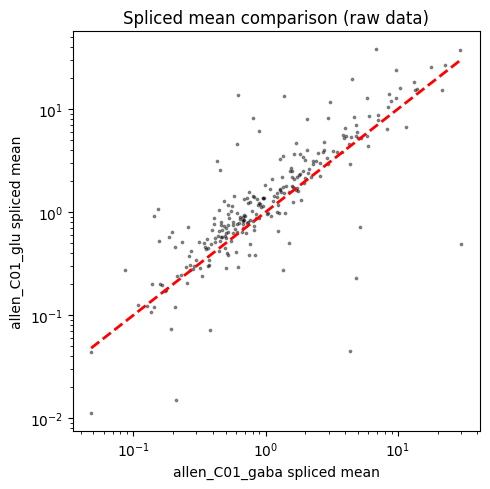

In [18]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
m1 = np.asarray([sd_arr[0].moments[x]['S_mean']  for x in range(n_genes)])
m2 = np.asarray([sd_arr[1].moments[x]['S_mean'] for x in range(n_genes)])
ax1.scatter(m1,m2,3,'k',alpha=0.4)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(dataset_names[0] + ' mature mean')
ax1.set_ylabel(dataset_names[1] + ' mature mean')
ax1.set_title('Mature mean comparison (raw data)')
xl = [min(m1),max(m1)]
ax1.plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

Raw means show changes of up to two orders of magnitude.

In [20]:
print((m1/m2).min())
print((m1/m2).max())

0.045038088694264164
94.94853737811484


<>:7: DeprecationWarning: invalid escape sequence \l
<>:7: DeprecationWarning: invalid escape sequence \l
<ipython-input-21-18c700ed5b6a>:7: DeprecationWarning: invalid escape sequence \l
  ax1.set_title('Normalized + $\log_2$ transformed')


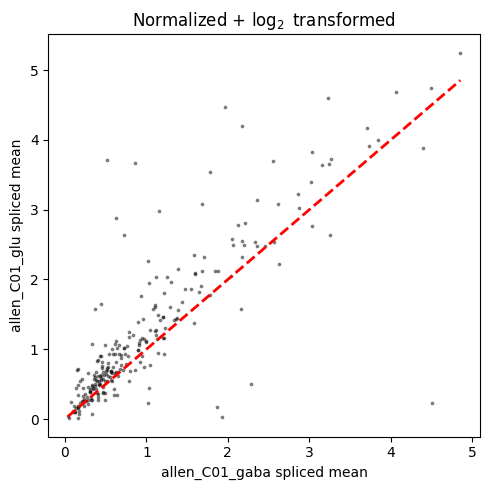

In [21]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
m1norm = monod.extract_data.normalize_count_matrix(sd_arr[0].layers[1],logbase=2).mean(1)
m2norm = monod.extract_data.normalize_count_matrix(sd_arr[1].layers[1],logbase=2).mean(1)
ax1.scatter(m1norm,m2norm,3,'k',alpha=0.4)
ax1.set_xlabel(dataset_names[0] + ' spliced mean')
ax1.set_ylabel(dataset_names[1] + ' spliced mean')
ax1.set_title('Normalized + $\log_2$ transformed')
xl = [min(m1norm),max(m1norm)]
ax1.plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

 Note we subtract here, because we have applied a $\log_2$ transformation to the raw data. 

In [23]:
print((m1norm-m2norm).min())
print((m1norm-m2norm).max())

-3.205008630127209
4.274493152212949


Tthe $t$-test identifies a handful of genes.

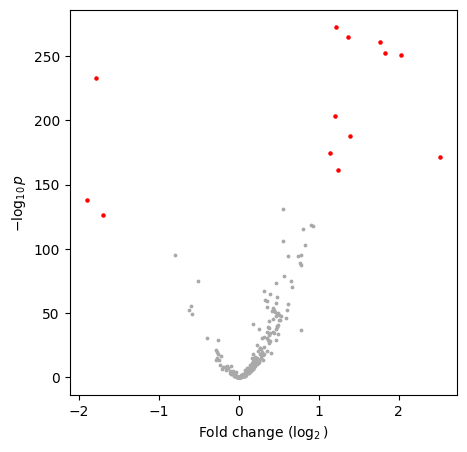

In [25]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
gf_ttest,fc_ = monod.analysis.diffexp_mean(sd_arr[0],sd_arr[1],lognormalize=True,viz=True,method='ttest',\
                                ax1=ax1,pval_thr=pval_thr,bonferroni=True)
fig_string = sr_arr[0].batch_analysis_string+'/ttest_s.png'
plt.savefig(fig_string,dpi=450)

## DE-$\theta$

With the parameter fits, we can attempt to identify genes that show differences in distributions, which are not necessarily reflected in the means.

Inspect the parameter trends. These are slightly less correlated than means.

INFO:root:Figure stored to ./fits/gg_230417_026_mouse_1/analysis_figures/pair_parameter_comparison_mouse.png.


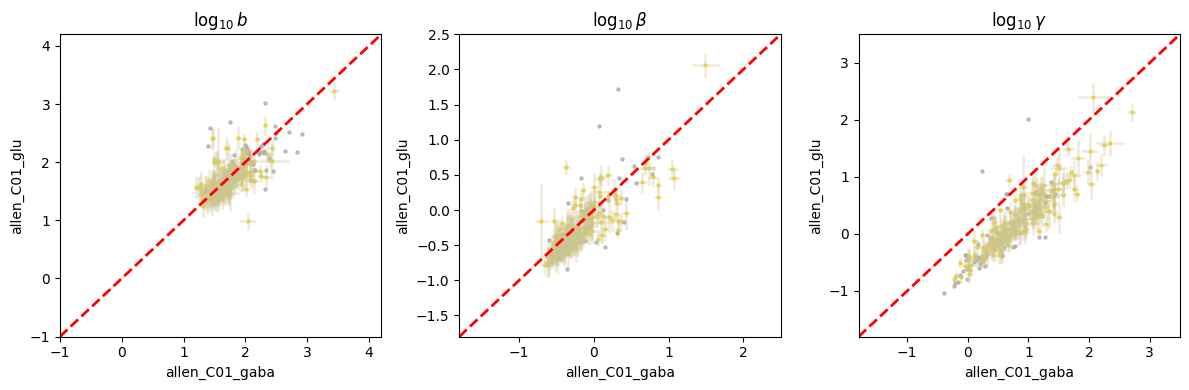

In [26]:
monod.analysis.plot_params_for_pair(sr_arr[0],sr_arr[1],\
                        distinguish_rej=True,plot_errorbars=True,meta = 'mouse',
                        xlabel = dataset_names[0],\
                        ylabel = dataset_names[1])

A handful of genes can be identified as outliers.

INFO:root:Figure stored to ./fits/gg_230417_026_mouse_1/analysis_figures/parameter_residuals_mouse.png.


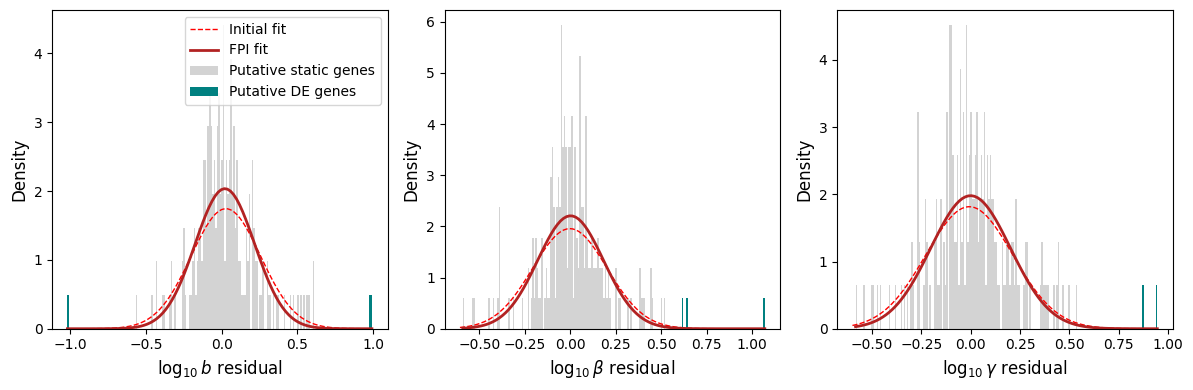

In [27]:
dr_analysis = monod.analysis.diffexp_pars(sr_arr[0],sr_arr[1],viz=True,modeltype='id',meta= 'mouse',use_sigma=True)

In [28]:
dr_par = dr_analysis[1].T
fc_par = dr_analysis[3].T
dr_par = np.concatenate((dr_par,((dr_par[:,1] & dr_par[:,2]))[:,None]),1)
fc_par = np.concatenate((fc_par,(-(fc_par[:,1]+fc_par[:,2])/2)[:,None]),1)

What are these genes? 

In [29]:
for k in range(n_phys_pars+1):
    print(param_names_text[k])
    print(gn[dr_par[:,k]])

log10 b
['Dkk3' 'Adam12' 'Mast3']
log10 beta
['Dpysl5' 'Crispld2' 'Mpi']
log10 gamma
['Dpysl5' 'Crispld2']
log10 ki
['Dpysl5' 'Crispld2']


We have identified some genes as frequency-modulated. Is frequency modulation common in general?

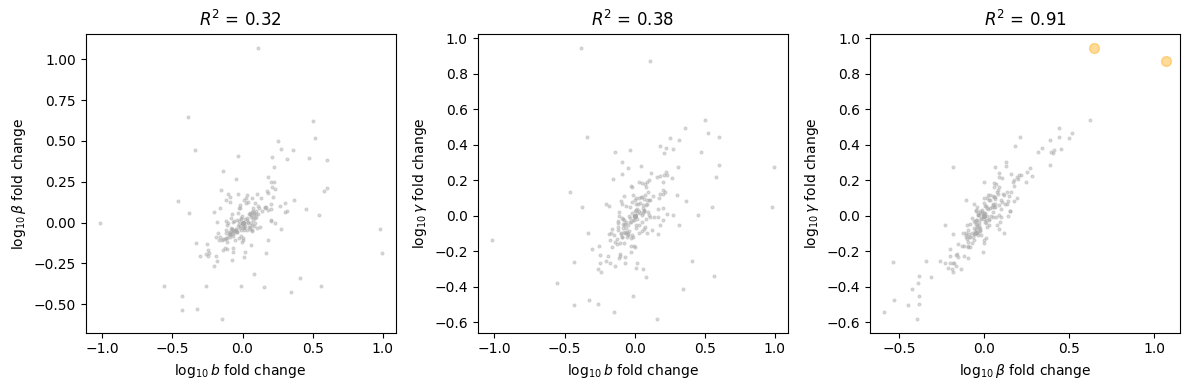

In [30]:
pairs = [[0,1],[0,2],[1,2]]
q=0
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
q=0
for pair in pairs:
    k1 = pair[0]
    k2 = pair[1]
    gf = dr_par[:,k1] & dr_par[:,k2]

    x = fc_par[:,k1]
    y = fc_par[:,k2]
    x[np.isnan(x)] = 0 
    y[np.isnan(y)] = 0

    ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
    ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
    ax1[q].set_xlabel(param_names[k1]+' fold change')
    ax1[q].set_ylabel(param_names[k2]+' fold change')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(x,y)[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    q+=1
fig1.tight_layout()


## Raw data examination

### Burst size

Do the fit distributions actually match the data? First, consider those assigned to burst size modulation.

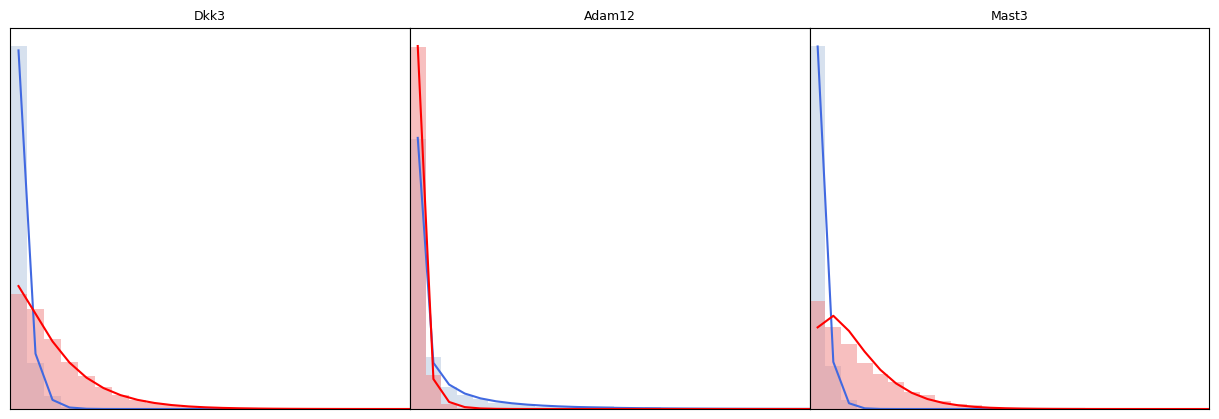

In [32]:
gf = dr_par[:,0]
monod.analysis.compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='nascent',logscale=False,sz=(1,3),figsize=(12,4))

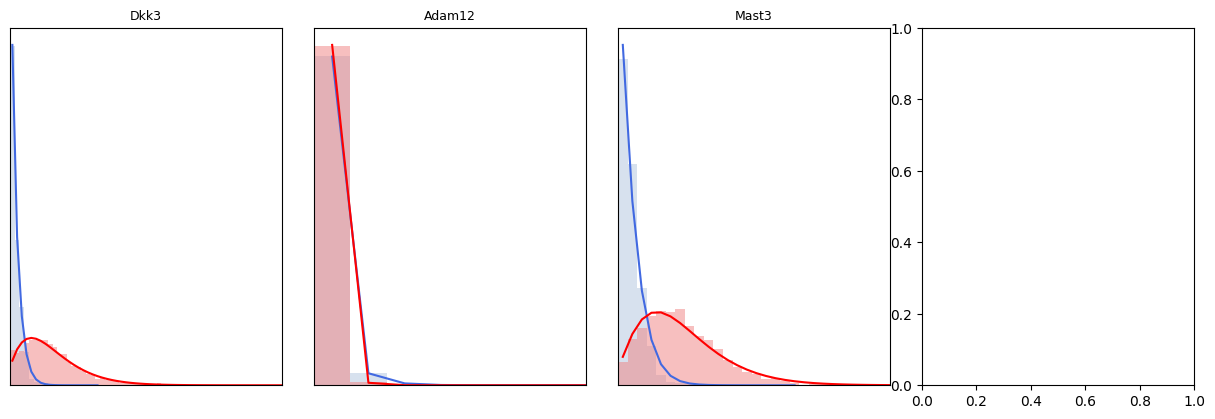

In [37]:
monod.analysis.compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='mature',logscale=False,sz=(1,4),figsize=(12,4))

They appear to match the data fairly well.

How much do the parameters change? The model predicts above 0.5 absolute $\log_2$ change.

In [38]:
fc_par[gf][:,0]

array([ 0.9781156 , -1.0193837 ,  0.99197114])

How much do the means change? Only modestly for *Adam12*.

In [39]:
fc_[gf]

array([ 2.25840649, -0.03937813,  1.91914591])

### Burst frequency

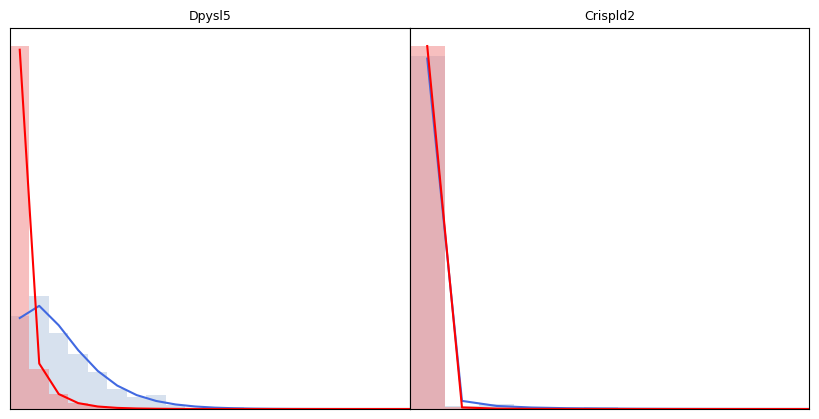

In [43]:
gf = dr_par[:,-1]
monod.analysis.compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='nascent',logscale=False,sz=(1,2),figsize=(8,4))

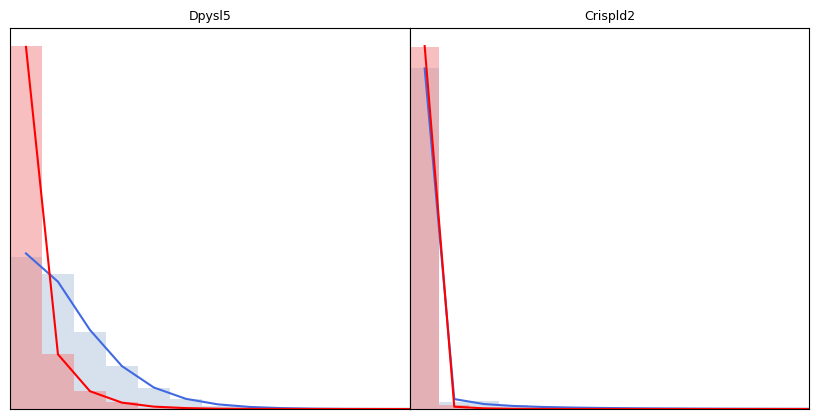

In [44]:
monod.analysis.compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='mature',logscale=False,sz=(1,2),figsize=(8,4))

The differences for frequency-modulated genes are more subtle.

In [46]:
fc_par[gf][:,3]

array([-0.97055898, -0.79444748])

In [47]:
fc_[gf]

array([-0.79060804, -0.14451298])

In [49]:
!tar -czvf sample_fits.tar.gz fits

fits/
fits/gg_220615_022_mouse_1/
fits/gg_220615_022_mouse_1/allen_C01_gaba/
fits/gg_220615_022_mouse_1/allen_C01_gaba/raw.sd
fits/gg_220615_022_mouse_1/allen_C01_gaba/diagnostic_figures/
fits/gg_220615_022_mouse_1/allen_C01_gaba/diagnostic_figures/allen_C01_gaba.png
fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/
fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/
fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/parameter_marginals.png
fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/kldiv.png
fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling.png
fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/chisquare_stability.png
fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png
fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/length_dependence.png
f